# CS-386 Artificial Intelligence Lab

# Project - 3 : Mining E-Commerce Customer Reviews

# Shivam Pandey (160010003)

## Question 1: Preprocess the corpus of customer reviews dataset

In [14]:
#-----------------------------------------------------------------------------------------------
                            ## Importing all necessary python libraries
#-----------------------------------------------------------------------------------------------
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.spatial.distance import cosine
import os
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
import time


#----------------------------------------------------------------------------------------------
                    ## Pre-processing entails "Removing Punctuations", "Lower-Casing"
#----------------------------------------------------------------------------------------------
Clothing_ID = 862

corpus_pandas_dataFrame = pd.read_csv("../input/Womens Clothing E-Commerce Reviews.csv")
corpus_with_particular_ID = corpus_pandas_dataFrame[corpus_pandas_dataFrame["Clothing ID"] == Clothing_ID]
#entire_corpus = corpus_pandas_dataFrame.dropna(subset=['Review Text'])
corpus_with_particular_ID = corpus_with_particular_ID.dropna(subset=['Review Text'])
review_text = corpus_with_particular_ID["Review Text"]
#review_text = entire_corpus["Review Text"]
#print(review_text)

corpus = list() # This will be a list of strings, where each string will be a "document"

## Pre-processing Corpus
for each_review in review_text:
    preprocessed_review = each_review.lower() # Lower-casing each document
    preprocessed_review = re.sub(r'[^A-Za-z ]', '', preprocessed_review) # removing Punctuations from each document
    corpus.append(preprocessed_review)

#print(corpus) # print the pre-processed corpus


## Question 2: Remove stopwords, standardize tokens

In [15]:
#-----------------------------------------------------------------------------------------------
                    ## Stemming and Lemmatization - Applying to the pre-processed corpus
#-----------------------------------------------------------------------------------------------
lemmatizer = WordNetLemmatizer()
for each_document_index in range(len(corpus)):
    list_of_words = corpus[each_document_index].strip().split()
    
    for each_word_index in range(len(list_of_words)) :
        list_of_words[each_word_index] = lemmatizer.lemmatize(list_of_words[each_word_index])
    
    corpus[each_document_index] = ' '.join(list_of_words)

    
#-----------------------------------------------------------------------------------------------
                                # STOPWORDS Removal from the Corpus #
#-----------------------------------------------------------------------------------------------
stopWords = stopwords.words('english')

## Pre-processing Stopwords
for stopWord_index in range(len(stopWords)):
    stopWords[stopWord_index] = stopWords[stopWord_index].lower() # Lower-casing
    stopWords[stopWord_index] = re.sub(r'[^A-Za-z ]','',stopWords[stopWord_index]) # removing Punctuations

vectorizer = CountVectorizer(min_df=0, stop_words=stopWords, strip_accents='ascii')


#-----------------------------------------------------------------------------------------------
                            ## Building the Vocabulary out of the corpus 
#-----------------------------------------------------------------------------------------------
docs_tf = vectorizer.fit_transform(corpus)
vocabulary_terms = vectorizer.get_feature_names()
#print(docs_tf)
#print(vocabulary_terms) # Its a list of "vocabulary words" developed from the corpus

key_words = ['lovely','top']

## Question 3: Build the Term-Frequency Inverse-Document-Frequency (TF-IDF) matrix and apply the Latent Semantic Analysis (LSA) method

In [16]:

#--------------------------------------------------------------------------------------------------
    ## Building the Term-Frequency Inverse-Document-Frequency (TF-IDF) matrix and performaing IR
#--------------------------------------------------------------------------------------------------
# Composite model for both the corpus and the query 
docs_query_tf = vectorizer.transform(corpus + [' '.join(key_words)]) 
transformer = TfidfTransformer(smooth_idf = False)
tfidf = transformer.fit_transform(docs_query_tf.toarray())

# D(no. of documents) x V(cardinality of vocabulary set) document-term matrix
tfidf_matrix = tfidf.toarray()[:-1] # Excluding the last column which contains the key_words
#print(len(tfidf_matrix))

# 1 x V query-term vector 
query_tfidf = tfidf.toarray()[-1] 

#print (tfidf_matrix)
#print (query_tfidf)

TFIDF_start_time = time.time()
query_doc_tfidf_cos_dist = [cosine(query_tfidf, doc_tfidf) for doc_tfidf in tfidf_matrix]
TFIDF_end_time = time.time()
query_doc_tfidf_sort_index = np.argsort(np.array(query_doc_tfidf_cos_dist))


#print(query_doc_tfidf_sort_index)

print("#-------------------------------------------------------------------------------------------------------\n\t## Building the Term-Frequency Inverse-Document-Frequency (TF-IDF) matrix and performaing IR\n#-------------------------------------------------------------------------------------------------------")
for rank, sort_index in enumerate(query_doc_tfidf_sort_index):
    print (rank, query_doc_tfidf_cos_dist[sort_index], corpus[sort_index])


#-------------------------------------------------------------------------------------------------------
	## Building the Term-Frequency Inverse-Document-Frequency (TF-IDF) matrix and performaing IR
#-------------------------------------------------------------------------------------------------------
0 0.6084722201847717 i adore this top lovely color fit is very flattering can dress up for work with a skirt or down with jean
1 0.6173126589257063 this top is lovely to look at and to wear one to reach for frequently
2 0.6626893446476587 this top is really cute the plum is a lovely color and the top fit true to size love the back detailing and it is really good tshirt quality
3 0.6683913521363961 very comfortable great quality with beautiful crocheted front top and lovely blend of color
4 0.7152264415109727 the shirt fit loosely but not baggy beautiful detail on the back and shoulder very soft and lovely material
5 0.7259657319039243 i like this shirt it quite lovely i ordered it in min

#-----------------------------------------------------------------------------------------------------
	## Performing IR using LSA with SVD on TF-matrix
#-----------------------------------------------------------------------------------------------------
0 1.1972186648723238e-06 i purchased this top in the blue stripe and red after washing the red top it lost color in little spot and also ha little hole along the seam the blue washed fine overall it is a very cute top and great for summer
1 1.4295101787631381e-05 i really like this top excellent over a casual dress perfect for spring summer and fall
2 2.156105671458075e-05 the floral pattern on this tank tranforms it to a beautiful piece i usually tend to avoid top with full pattern because it tends to look busy but not with this top im usually wear sm with retailer brand depending with the design this tank ha loose bottom section so the s is tt for me
3 3.406716592668779e-05 this is a really nice top especially for the price i am dd 

Text(0,0.5,'Component 2')

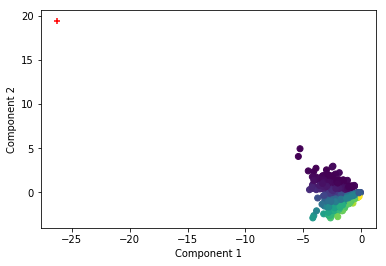

In [17]:
#----------------------------------------------------------------------------------------
            ## Performing IR using LSA with SVD on TF-matrix
#----------------------------------------------------------------------------------------
tf_matrix = docs_tf.toarray() # D x V matrix 
A = tf_matrix.T 

U, s, V = np.linalg.svd(A, full_matrices=1, compute_uv=1)

K = 2 # number of components

A_reduced = np.dot(U[:,:K], np.dot(np.diag(s[:K]), V[:K, :])) # V x D matrix (Reconstruction Matrix)
docs_rep = np.dot(np.diag(s[:K]), V[:K, :]).T # D x K matrix 
terms_rep = np.dot(U[:,:K], np.diag(s[:K])) # V x K matrix 

## We represent the query in the LSA space
key_word_indices = [vocabulary_terms.index(key_word) for key_word in key_words] # vocabulary indices 
key_words_rep = terms_rep[key_word_indices,:]
query_rep = np.sum(key_words_rep, axis = 0)
#print (query_rep)

TF_LSA_start_time = time.time()
query_doc_cos_dist = [cosine(query_rep, doc_rep) for doc_rep in docs_rep]
TF_LSA_end_time = time.time()
query_doc_sort_index = np.argsort(np.array(query_doc_cos_dist))


print("#-----------------------------------------------------------------------------------------------------\n\t## Performing IR using LSA with SVD on TF-matrix\n#-----------------------------------------------------------------------------------------------------")
for rank, sort_index in enumerate(query_doc_sort_index):
    print (rank, query_doc_cos_dist[sort_index], corpus[sort_index])

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot()
plt.scatter(docs_rep[:,0], docs_rep[:,1], c=query_doc_cos_dist) # all documents 
plt.scatter(query_rep[0], query_rep[1], marker='+', c='red') # the query 
plt.xlabel("Component 1")
plt.ylabel("Component 2")

#-----------------------------------------------------------------------------------------------------
	## Performing IR using LSA with SVD on TFIDF-matrix
#-----------------------------------------------------------------------------------------------------
0 5.062994182791769e-07 this blouse doe have a flowy boxy shape to it but the detail make up for that when i wear it tucked into a skirt it look wonderfully flattering i tried on an x and considered looking for a xx but i feel that size would probably end up being too short instead of more fitted
1 2.046704288050094e-06 this top is gorgeous the picture just doe not do it justice i bought it solely based on the one review that said it look very good and it doe the velvet work at the top make it look very dressy the sleeve are not with big hole that show too much the top and sleeve are perfect i really like this top i cant believe that the photo doesnt show it gorgeousness it look so much better inperson i so wish it came in more col

Text(0,0.5,'Component 2')

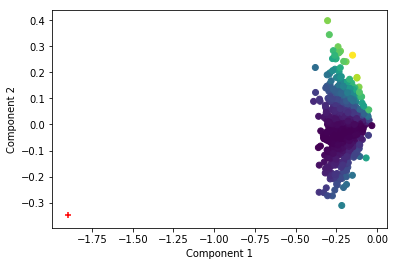

In [18]:
#-----------------------------------------------------------------------------------------
                ## Performing IR using LSA with SVD on TFIDF-matrix
#-----------------------------------------------------------------------------------------
docs_query_tf = vectorizer.transform(corpus) 
transformer = TfidfTransformer(smooth_idf = False)
tfidf = transformer.fit_transform(docs_query_tf.toarray())

tfidf_matrix = tfidf.toarray() # D x V matrix 
A = tfidf_matrix.T 

U, s, V = np.linalg.svd(A, full_matrices=1, compute_uv=1)

K = 2 # number of components

A_reduced = np.dot(U[:,:K], np.dot(np.diag(s[:K]), V[:K, :])) # V x D matrix (Reconstruction Matrix)
docs_rep = np.dot(np.diag(s[:K]), V[:K, :]).T # D x K matrix 
terms_rep = np.dot(U[:,:K], np.diag(s[:K])) # V x K matrix 

## We represent the query in the LSA space
key_word_indices = [vocabulary_terms.index(key_word) for key_word in key_words] # vocabulary indices 
key_words_rep = terms_rep[key_word_indices,:]
query_rep = np.sum(key_words_rep, axis = 0)
#print (query_rep)

TFIDF_LSA_start_time = time.time()
query_doc_cos_dist = [cosine(query_rep, doc_rep) for doc_rep in docs_rep]
TFIDF_LSA_end_time = time.time()
query_doc_sort_index = np.argsort(np.array(query_doc_cos_dist))


print("#-----------------------------------------------------------------------------------------------------\n\t## Performing IR using LSA with SVD on TFIDF-matrix\n#-----------------------------------------------------------------------------------------------------")
for rank, sort_index in enumerate(query_doc_sort_index):
    print (rank, query_doc_cos_dist[sort_index], corpus[sort_index])

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot()
plt.scatter(docs_rep[:,0], docs_rep[:,1], c=query_doc_cos_dist) # all documents 
plt.scatter(query_rep[0], query_rep[1], marker='+', c='red') # the query 
plt.xlabel("Component 1")
plt.ylabel("Component 2")

## Question 4: Compare the performance of Information Retrieval (IR) using both TF-IDF and LSA methods

## Analysis and Comparision of the two methods

### Time

In [19]:
TFIDF_running_time = TFIDF_end_time-TFIDF_start_time
TF_LSA_running_time = TF_LSA_end_time-TF_LSA_start_time

print("TFIDF Running Time :",TFIDF_running_time,"secs\nLSA on TF-matrix running time :",TF_LSA_running_time,"secs")

if TF_LSA_running_time < TFIDF_running_time :
    print("\n---> We discern that 'LSA with TF' method runs faster than the TFIDF method.")
else :
    print("\n---> We discern that TFIDF method runs faster than the 'LSA with TF' method.")

TFIDF Running Time : 0.031867265701293945 secs
LSA on TF-matrix running time : 0.024209260940551758 secs

---> We discern that 'LSA with TF' method runs faster than the TFIDF method.


### Space

Clearly, LSA will take lesser space than TFIDF method. The reason being, in TFIDF method we need to deal with 'D x V' matrix ( D = no. of documents, V = no. of words). Elseways, in LSA method, we need to store only 'D x K' matrix, ( K = reduced dimention), and the Eigen matrix 'V x K'.

### Result

- Query Words = "lovely","top"

#### TFIDF Output on query

1. 0.6084722201847717 i adore this top lovely color fit is very flattering can dress up for work with a skirt or down with jean
2. 0.6173126589257063 this top is lovely to look at and to wear one to reach for frequently
3. 0.6626893446476587 this top is really cute the plum is a lovely color and the top fit true to size love the back detailing and it is really good tshirt quality
4. 0.6683913521363961 very comfortable great quality with beautiful crocheted front top and lovely blend of color
5. 0.7152264415109727 the shirt fit loosely but not baggy beautiful detail on the back and shoulder very soft and lovely material

#### LSA on TF-matrix output on query

1. 1.1972186648723238e-06 i purchased this top in the blue stripe and red after washing the red top it lost color in little spot and also ha little hole along the seam the blue washed fine overall it is a very cute top and great for summer
2. 1.4295101787631381e-05 i really like this top excellent over a casual dress perfect for spring summer and fall
3. 2.156105671458075e-05 the floral pattern on this tank tranforms it to a beautiful piece i usually tend to avoid top with full pattern because it tends to look busy but not with this top im usually wear sm with retailer brand depending with the design this tank ha loose bottom section so the s is tt for me
4. 3.406716592668779e-05 this is a really nice top especially for the price i am dd lb and normally wear a medium in dolan top in this top i purchased size small since the gathered front provides ample room for my bust some reviewer have found this top to be on the boxy side i can see that if you dont size down a i did i found the medium to have too much fabric and look very baggy whereas the small wa perfect i do wish this top wa a tad bit longer and le sheer though white top should be
5. 7.836218830681307e-05 beautiful top but delicate i wore it to school and the strap on my backpack caused some pilling other than that it is beautiful and vibrant just make sure you arent doingwearing anything that will rub it continuously since the fabric is delicate

#### LSA on TFIDF-matrix output on query

1.  5.062994182791769e-07 this blouse doe have a flowy boxy shape to it but the detail make up for that when i wear it tucked into a skirt it look wonderfully flattering i tried on an x and considered looking for a xx but i feel that size would probably end up being too short instead of more fitted
2.  2.046704288050094e-06 this top is gorgeous the picture just doe not do it justice i bought it solely based on the one review that said it look very good and it doe the velvet work at the top make it look very dressy the sleeve are not with big hole that show too much the top and sleeve are perfect i really like this top i cant believe that the photo doesnt show it gorgeousness it look so much better inperson i so wish it came in more color
3.  3.838548218393356e-06 this cute top is made in the usa yay it is a flattering cut and look great under jacket i prefer the ivory color and feel of the fabric the black and white wa cute but hung strangely and felt stiff i am size smmed c and went with the small cowl is cozy and can be styled to keep you warm
4.  5.033087118855306e-06 i didnt pay much attn to this online im not much on front hook tie closure well saw today at the local store decided to try on both the s m i am usually a s in top but the m wa only a bit more roomy longer than the s so i went with the size m i thought the styling of it paired well w the pilcro cord skinny i had on looked much better than the pic online i have other pilcro skinny cord jean in v color so i think this top will work out well for me love the sleev
5.  1.0790010219530188e-05 this top fit so well and look much better on than in the picture

### Conclusion

- We scrutinize that in terms of Space and time complexity, LSA using SVD is better than TFIDF method.
- If we try to compare the ranking given by both methods to the corpus on some query words, it is subjective that which gives better result. One might like the result of TFIDF over LSA , someone else might like the other way around.
- Upon close inspection, we discern that LSA entails context understandings given the key words, i.e. , it not only just gives the documents with given keywords, it also shows documents which mean the same in context involving some different words.
- In case of TFIDF, we discern that it shows those documents first, which has the exact keywords given by the user.
- Ultimately, the choice of using TFIDF or LSA might vary from person to person. But undoubtedly, LSA using SVD is better than TFIDF method from computational aspects such as space-time complexity.